In [1]:
from IPython.display import display
from IPython.display import Image
from tensorflow.keras.applications import vgg19
from tqdm.auto import trange
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import time
tf.random.set_seed(0)

# 이미지

## Content Image
귀여운 강아지 사진이다.

90112/83281 [================================] - 0s 0us/step


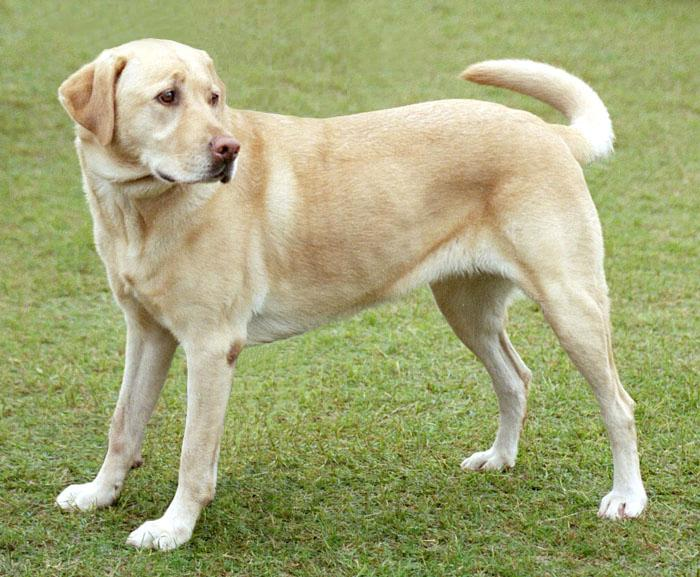

In [2]:
content_path = keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
display(Image(content_path))

## Style Image
바실리 칸딘스키의 작품이다.

196608/195196 [==============================] - 0s 0us/step


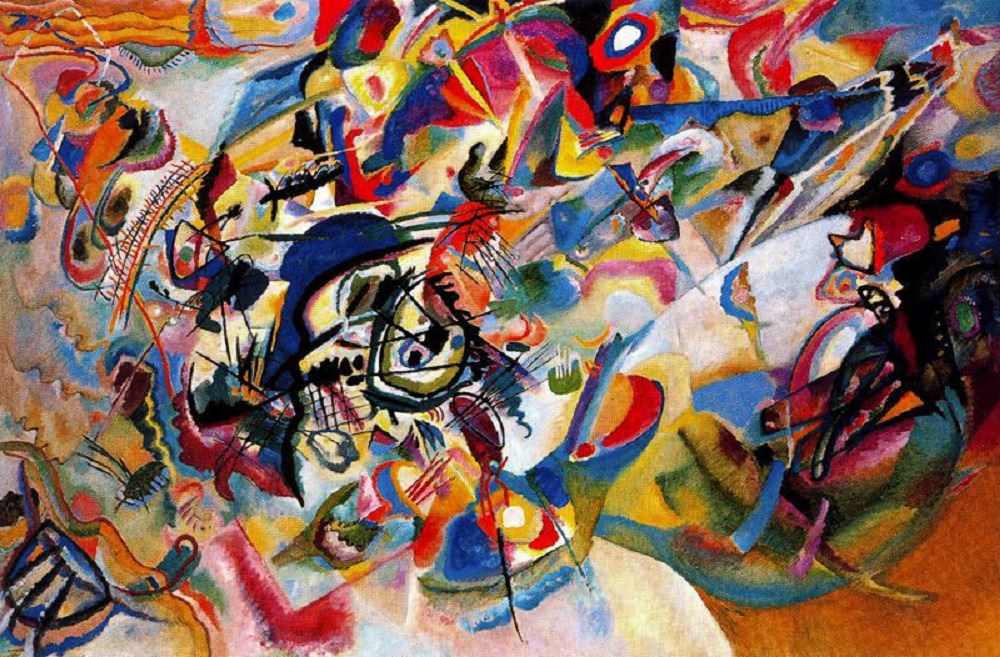

In [3]:
style_path = keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')
display(Image(style_path))

# VGG-19
VGG-19는 real-world 이미지를 1000가지로 분류하는 ImageNet 데이터셋에 대해 학습된 모델이다. 이 문서에서는 온라인으로 제공되는 사전 학습된 파라미터를 이용한다.

In [4]:
model = vgg19.VGG19(weights='imagenet', include_top=False)

80142336/80134624 [==============================] - 7s 0us/step


## 이미지 전처리 / 역처리 함수

In [5]:
img_width, img_height = keras.preprocessing.image.load_img(content_path).size

In [6]:
def preprocess_image(image_path):
    img = keras.preprocessing.image.load_img(image_path, target_size=(img_height, img_width))
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)

def deprocess_image(x):
    x = x.reshape((img_height, img_width, 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# 이미지 변환
이미지의 화풍과 내용을 담는 피쳐를 뽑아 이미지를 변환하는 작업을 진행한다.

## 이미지의 화풍 특징
이미지의 화풍 특징은 각 특성 맵의 평균과 특성 맵들 사이의 상관관계로 설명할 수 있는데, 자세한 내용은 이 문서에서는 다루지 않는다.
아래의 코드는 이미지의 화풍 특징을 계산할 수 있도록 하는 함수이다.

In [7]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / (num_locations)

## 이미지 특징
뉴럴네트워크의 각 층은 이미지의 특징을 나타낸다고 알려져있다. 이 중 원하는 층의 출력만을 얻어내는 모델을 구성한다.

In [8]:
style_layer_names = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1',
]
content_layer_names = ['block5_conv2']

In [9]:
class StyleContentModel(keras.Model):
    def __init__(self, model, style_layer_names, content_layer_names):
        super(StyleContentModel, self).__init__()
        self.style_layer_names = style_layer_names
        self.content_layer_names = content_layer_names
        
        style_layer_outputs = [model.get_layer(name).output for name in style_layer_names]
        content_layer_outputs = [model.get_layer(name).output for name in content_layer_names]
        self.model = keras.Model([model.input], style_layer_outputs + content_layer_outputs)
        self.num_style_layers = len(style_layer_outputs)
        self.model.trainable = False
        
    def call(self, inputs):
        outputs = self.model(inputs)
        
        style_outputs = outputs[:self.num_style_layers]        
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
        style_dict = dict(zip(self.style_layer_names, style_outputs))
        
        content_outputs = outputs[self.num_style_layers:]
        content_dict = dict(zip(self.content_layer_names, content_outputs))
        
        return {'style': style_dict, 'content': content_dict}

In [10]:
extractor = StyleContentModel(model, style_layer_names, content_layer_names)

## Loss
이미지의 style loss와 content loss를 정의한다.

In [11]:
style_weight = 1e-2
content_weight = 1e4

In [12]:
def style_loss(style_outputs, style_targets):
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name])**2)
                          for name in style_outputs.keys()])
    style_loss /= len(style_outputs)
    return style_loss

In [13]:
def content_loss(content_outputs, content_targets):
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name])**2)
                            for name in content_outputs.keys()])
    content_loss /= len(content_outputs)
    return content_loss

In [14]:
def style_content_loss(outputs, targets, style_weight=1, content_weight=1):
    style_outputs = outputs['style']
    style_targets = targets['style']
    sl = style_loss(style_outputs, style_targets)
    
    content_outputs = outputs['content']
    content_targets = targets['content']
    cl = style_loss(content_outputs, content_targets)
    
    loss = style_weight * sl + content_weight * cl
    return loss

## Gradient
정의한 loss를 바탕으로 gradient를 계산한다.

In [15]:
@tf.function
def compute_loss_and_grads(extractor, image, targets, style_weight=1, content_weight=1):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs, targets, style_weight, content_weight)
    grads = tape.gradient(loss, image)
    return loss, grads

# Style Transfer
정의한 loss를 바탕으로 계산한 gradient를 이용하여 이미지를 변환한다.

## Style Target

In [16]:
style_image = preprocess_image(style_path)
style_targets = extractor(style_image)['style']

## Content Target

In [17]:
content_image = preprocess_image(content_path)
content_targets = extractor(content_image)['content']

## Optimizer
경사하강법을 이용하여 loss를 최소화 하도록 최적화하는 모듈이다.

In [18]:
opt = tf.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)

## Style Transfer

In [19]:
image = tf.Variable(preprocess_image(content_path))
targets = {'style': style_targets, 'content': content_targets}

In [20]:
start = time.time()
iterations = 1000
pbar = trange(iterations, postfix={'loss': '-'})
for i in pbar:
    loss, grads = compute_loss_and_grads(extractor, image, targets, style_weight, content_weight)
    opt.apply_gradients([(grads, image)])
    pbar.set_postfix({'loss': f'{loss:.2f}'})
    if (i + 1) % 100 == 0:
        img = deprocess_image(image.numpy())
        fname = f'styled_content_image_at_iteration_{i + 1}.png'
        keras.preprocessing.image.save_img(fname, img)
end = time.time()
print(f'소요시간(초): {end - start}')

  0%|          | 0/1000 [00:00<?, ?it/s, loss=-]

소요시간(초): 77.09936237335205


## 생성된 이미지

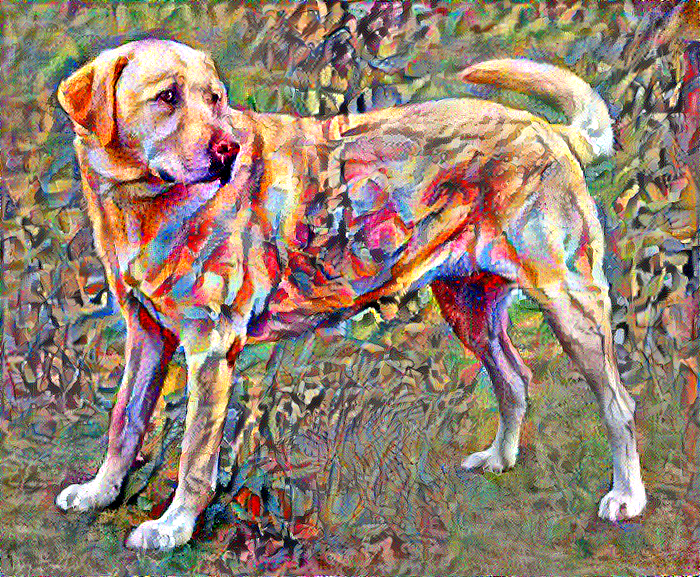

In [21]:
display(Image(f'styled_content_image_at_iteration_{iterations}.png'))